# Introduction

In this notebook, I apply the complete data analysis process with machine learning to predict the EPS in binary format indicating if the input date is good or bad EPS which giving us an initial idea of the stock's quality prior going deep analysis for such stock.

### __Data analysis process:__

__Data preprocessing__
- Rename columns
- Handle missing values
- Check multicollinearity

__EDA__
- Adjusted inflation rate on net income and market cap to illustrate the real value of the company
- Inspect the cash flow
- Inspect the average market cap in each industry
- Inspect the average in every column in each industry
- Determine the target variable for machine learning model
- Handle outliers in the target variable

__Feature Engineering__
- Create the target variable in the form of a binary classification
- Feature Selection with machine learning model

__Modeling__
- Apply classification models
- Hyperparameter tuning with GridSearchCV

__Evaluation__
- Feature importance
- Confusion matrix
- Accuracy
- Classification report
- ROC curve

__Summary__

Finally I have summarized the finding, assumption and further work to do and improve this notebook.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/financial-statements-of-major-companies2009-2023/Financial Statements.csv


In [2]:
# Set the float format of pandas output for this notebook
# pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 100

In [3]:
df = pd.read_csv('/kaggle/input/financial-statements-of-major-companies2009-2023/Financial Statements.csv')
df.head()

,Year,Company,Category,Market Cap(in B USD),Revenue,Gross Profit,Net Income,Earning Per Share,EBITDA,Share Holder Equity,Cash Flow from Operating,Cash Flow from Investing,Cash Flow from Financial Activities,Current Ratio,Debt/Equity Ratio,ROE,ROA,ROI,Net Profit Margin,Free Cash Flow per Share,Return on Tangible Equity,Number of Employees,Inflation Rate(in US)
0,2022,AAPL,IT,2066.94,394328.0,170782.0,99803.0,6.11,130541.0,50672.0,122151.0,-22354.0,-110749.0,0.8794,2.3695,196.9589,28.2924,66.6994,25.3096,1.3146,196.9589,164000,8.0028
1,2021,AAPL,IT,2913.28,365817.0,152836.0,94680.0,5.61,120233.0,63090.0,104038.0,-14545.0,-93353.0,1.0746,1.9768,150.0713,26.9742,54.9839,25.8818,1.3261,150.0713,154000,4.6979
2,2020,AAPL,IT,2255.97,274515.0,104956.0,57411.0,3.28,77344.0,65339.0,80674.0,-4289.0,-86820.0,1.3636,1.7208,87.8664,17.7256,35.0054,20.9136,1.0183,87.8664,147000,1.2336
3,2019,AAPL,IT,1304.76,260174.0,98392.0,55256.0,2.97,76477.0,90488.0,69391.0,45896.0,-90976.0,1.5401,1.1940,61.0645,16.3230,30.3113,21.2381,-0.0388,61.0645,137000,1.8122
4,2018,AAPL,IT,748.54,265595.0,101839.0,59531.0,2.98,81801.0,107147.0,77434.0,16066.0,-87876.0,1.1329,1.0685,55.5601,16.2775,29.6348,22.4142,0.7414,55.5601,132000,2.4426


# Data Preprocessing

In [4]:
df1 = df.copy()

In [5]:
# Rename columns

df1.rename(columns={'Company ':'Company'}, inplace=True)
df1.rename(columns={'Market Cap(in B USD)':'Market_cap'}, inplace=True)
df1.rename(columns={'Inflation Rate(in US)':'Inflation_rate'}, inplace=True)
df1.rename(columns={'Category':'Industry'}, inplace=True)
df1['Industry'] = df1['Industry'].replace('BANK', 'Bank')
df1.columns = df1.columns.str.replace(' ', '_')

In [6]:
# Handle missing values

print(f'Before: {df1.isna().sum()}')
df1['Market_cap'].fillna(value= df1['Market_cap'].mean(), inplace=True)
print("*"*100)
print(f'After: {df1.isna().sum()}')

Before: Year                                   0
Company                                0
Industry                               0
Market_cap                             1
Revenue                                0
Gross_Profit                           0
Net_Income                             0
Earning_Per_Share                      0
EBITDA                                 0
Share_Holder_Equity                    0
Cash_Flow_from_Operating               0
Cash_Flow_from_Investing               0
Cash_Flow_from_Financial_Activities    0
Current_Ratio                          0
Debt/Equity_Ratio                      0
ROE                                    0
ROA                                    0
ROI                                    0
Net_Profit_Margin                      0
Free_Cash_Flow_per_Share               0
Return_on_Tangible_Equity              0
Number_of_Employees                    0
Inflation_rate                         0
dtype: int64
************************************

In [7]:
# Check Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Drop non-numeric columns
numeric_cols = df1.select_dtypes(include=[np.number]).columns
df_numeric = df1[numeric_cols]

# Add a constant term as needed for VIF calculation
df_numeric = sm.add_constant(df_numeric)

vif = pd.DataFrame()
vif["Features"] = df_numeric.columns
vif["VIF Factor"] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

print(vif)

                               Features     VIF Factor
0                                 const  525410.291166
1                                  Year       2.113588
2                            Market_cap       7.561018
3                               Revenue      21.359593
4                          Gross_Profit      29.267577
5                            Net_Income      34.423994
6                     Earning_Per_Share       2.808366
7                                EBITDA      45.056980
8                   Share_Holder_Equity       3.704176
9              Cash_Flow_from_Operating       5.983932
10             Cash_Flow_from_Investing       3.990457
11  Cash_Flow_from_Financial_Activities      10.783562
12                        Current_Ratio       2.112400
13                    Debt/Equity_Ratio       2.783454
14                                  ROE       2.265853
15                                  ROA       5.975821
16                                  ROI       1.074725
17        

## Result of VIF

As a rule of thumb, without domain knowledge, VIF above 5 could indicate a high collinear with the other variables resulting in overfitting models. However, in this scenario, the financial ratios and some variables are derived from similar formulas and calculation. Therefore, we will remain all and handle the multicollinearity with dimension reduction methods.

# Exploratory Data Analysis (EDA)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 161 non-null    int64  
 1   Company                              161 non-null    object 
 2   Industry                             161 non-null    object 
 3   Market_cap                           161 non-null    float64
 4   Revenue                              161 non-null    float64
 5   Gross_Profit                         161 non-null    float64
 6   Net_Income                           161 non-null    float64
 7   Earning_Per_Share                    161 non-null    float64
 8   EBITDA                               161 non-null    float64
 9   Share_Holder_Equity                  161 non-null    float64
 10  Cash_Flow_from_Operating             161 non-null    float64
 11  Cash_Flow_from_Investing        

In [9]:
df1.describe()

,Year,Market_cap,Revenue,Gross_Profit,Net_Income,Earning_Per_Share,EBITDA,Share_Holder_Equity,Cash_Flow_from_Operating,Cash_Flow_from_Investing,Cash_Flow_from_Financial_Activities,Current_Ratio,Debt/Equity_Ratio,ROE,ROA,ROI,Net_Profit_Margin,Free_Cash_Flow_per_Share,Return_on_Tangible_Equity,Number_of_Employees,Inflation_rate
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,1.610000e+02,161.000000
mean,2015.608696,337.604312,75862.600758,37383.463124,12276.607076,0.982886,20174.023974,57178.005273,20790.317839,-9581.533232,-8598.157950,2.035368,0.645520,12.432402,7.780479,11.881350,13.684964,0.192825,24.247542,1.457188e+05,2.231317
std,4.049960,539.409215,90786.895983,41669.093697,19417.421119,8.874504,26342.029803,54098.208311,27300.212516,16196.808177,20281.662795,1.660894,2.507177,44.777292,8.802462,93.384692,13.401767,15.412788,109.982817,2.234389e+05,1.959139
min,2009.000000,0.040000,3326.445000,1174.269000,-12244.000000,-90.480000,-6860.000000,-8210.300000,-39392.270000,-59611.000000,-110749.000000,0.220500,-11.775000,-212.606900,-23.723600,-742.105200,-44.696100,-121.502200,-554.174100,5.420000e+03,-0.355500
25%,2012.000000,41.280000,22820.400000,10396.000000,844.000000,0.340000,2310.000000,12353.000000,3502.000000,-17434.000000,-9059.288000,1.000000,0.077200,5.080000,0.828200,2.757900,4.827700,-0.361300,6.111800,2.990000e+04,1.261600
50%,2016.000000,113.630000,45992.040000,19561.000000,4757.800000,1.790000,9958.000000,47791.000000,7386.700000,-5904.000000,-1408.000000,1.341200,0.381800,14.501600,6.641100,13.469400,15.297700,0.265600,19.782200,9.600000e+04,1.812200
75%,2019.000000,356.310000,77849.000000,47722.000000,14136.000000,3.240000,27765.000000,91570.700000,31626.000000,-981.600000,735.300000,2.473400,0.891400,28.189300,14.701600,20.472300,22.934500,0.935400,36.980600,1.470000e+05,2.442600
max,2023.000000,2913.280000,513983.000000,225152.000000,99803.000000,14.980000,130541.000000,256144.000000,122151.000000,49749.000000,25928.000000,10.617800,9.332800,196.958900,31.154100,884.860500,36.686300,137.328700,1197.727000,1.608000e+06,8.002800


In [10]:
# Draw a sample for the lowest ROE

df1.loc[ (df1['ROE']== np.min(df1['ROE']))]

,Year,Company,Industry,Market_cap,Revenue,Gross_Profit,Net_Income,Earning_Per_Share,EBITDA,Share_Holder_Equity,Cash_Flow_from_Operating,Cash_Flow_from_Investing,Cash_Flow_from_Financial_Activities,Current_Ratio,Debt/Equity_Ratio,ROE,ROA,ROI,Net_Profit_Margin,Free_Cash_Flow_per_Share,Return_on_Tangible_Equity,Number_of_Employees,Inflation_rate
96,2016,MCD,FOOD,137.21,24621.9,10204.7,4686.5,5.44,9261.002,-2204.3,6059.6,-981.6,-11262.4,1.398,-11.775,-212.6069,15.1061,19.7958,19.0339,-0.21,-103.2087,375000,1.2616


In [11]:
# Adjust the net income and market cap after the inflation rate

def adjusted_inflation(df, net_income, market_cap, inflation):
    '''
    Get the adjusted net income and market cap
    '''
    df['Adjusted_net_income'] = df[net_income]/(1+df[inflation]/100)
    df['Adjusted_market_cap'] = df[market_cap]/(1+df[inflation]/100)
    return df

In [12]:
df1 = df1.sort_values('Year').reset_index(drop='index')
adjusted_inflation(df1, 'Net_Income', 'Market_cap', 'Inflation_rate')

df1.head()

,Year,Company,Industry,Market_cap,Revenue,Gross_Profit,Net_Income,Earning_Per_Share,EBITDA,Share_Holder_Equity,Cash_Flow_from_Operating,Cash_Flow_from_Investing,Cash_Flow_from_Financial_Activities,Current_Ratio,Debt/Equity_Ratio,ROE,ROA,ROI,Net_Profit_Margin,Free_Cash_Flow_per_Share,Return_on_Tangible_Equity,Number_of_Employees,Inflation_rate,Adjusted_net_income,Adjusted_market_cap
0,2009,AMZN,LOGI,58.24,24509.00,5531.00,902.00,0.1020,1507.0,5257.0,3293.00,-2337.00,-280.00,1.3304,0.2007,17.1581,6.5301,17.1581,3.6803,0.3303,22.4211,24300,-0.3555,905.218050,58.447782
1,2009,INTC,ELEC,112.65,35127.00,19561.00,4369.00,0.7700,10763.0,41704.0,11170.00,-7965.00,-2568.00,2.7871,0.0533,10.4762,8.2286,9.9856,12.4377,1.1789,11.7185,79800,-0.3555,4384.587208,113.051900
2,2009,AAPL,IT,189.80,42905.00,17222.00,8235.00,0.3243,12474.0,31640.0,10159.00,-17434.00,663.00,2.7425,0.0000,26.0272,17.3365,26.0272,19.1936,0.3550,26.4052,36800,-0.3555,8264.379870,190.477146
3,2009,BCS,Bank,36.84,45992.04,45992.04,5497.87,5.1200,1.0,91570.7,65523.51,18026.64,-1035.05,1.0000,8.5152,19.5283,0.8282,5.1862,12.0558,21.5535,22.9851,144200,-0.3555,5517.484658,36.971433
4,2009,AIG,Bank,4.04,75447.00,18614.00,-12244.00,-90.4800,27765.0,98076.0,18584.00,5778.00,-28997.00,1.0000,1.1552,-45.3061,-1.5123,-6.0641,-16.2286,137.3287,-13.9507,96000,-0.3555,-12287.682712,4.054413


In [13]:
# Check the value of these 2 variables to set the range in the plot.
df1[['Adjusted_net_income','Earning_Per_Share']].describe()

,Adjusted_net_income,Earning_Per_Share
count,161.000000,161.000000
mean,11911.912642,0.982886
std,18639.615268,8.874504
min,-12287.682712,-90.480000
25%,818.171948,0.340000
50%,4681.851013,1.790000
75%,13910.346361,3.240000
max,92407.789428,14.980000


In [14]:
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

df1['mk_int'] = df1['Adjusted_market_cap'].round().astype(int)

# Scatter plot with animation
fig = px.scatter(df1, x='Adjusted_net_income',y='Earning_Per_Share', color='Company', size="mk_int", size_max=40,
              animation_frame="Year", animation_group="Company", range_x=[-13000,100000], range_y=[-1,15])
fig.show()

# Line chart
fig = px.line(df1, x='Year', y='Adjusted_net_income', color='Company',title='Adjusted Net Income')
fig.show()

# Bar chart
fig = px.bar(df1, x='Year', y='Earning_Per_Share', color='Company', barmode="group", title='EPS')
fig.show()

## Do companies operate the cash flow effectively?

Cash flow margin can help to answer this question.

Based on the formula: $CF margin = \frac{cash flow}{net sales}$

Since there is no net sales available in this dataset, Cash flow from operating is used as it could represent sales and expenses.


In [15]:
df1['CF_margin'] = df1['Cash_Flow_from_Operating'] / df1['Revenue']

In [16]:
# By Company
fig = px.histogram(df1, x='Company', y='CF_margin', color='Year',barmode='group', title='Cash Flow Margin by Company', labels={'CF_margin': 'Cash Flow Margin'})
fig.show()

# By Year
fig = px.bar(df1, x='Year', y='CF_margin', color='Company',barmode='group', title='Cash Flow Margin by Year', labels={'CF_margin': 'Cash Flow Margin'})
fig.show()

# By Industry
fig = px.histogram(df1, x='Industry', y='CF_margin', color='Company',barmode='group', title='Cash Flow Margin by Industry', labels={'CF_margin': 'Cash Flow Margin'})
fig.show()

In [17]:
with pd.option_context('display.max_rows', 1000):
    print(df1.groupby(["Industry", "Year"])["CF_margin"].mean())

Industry       Year
Bank           2009    0.835495
               2010    0.408603
               2011    0.476740
               2012   -0.210323
               2013   -0.408004
               2014   -0.167571
               2015    0.341469
               2016    0.296502
               2017    1.361350
               2018    0.197016
               2019   -0.302348
               2020    1.332849
               2021    1.175145
               2022    0.642958
ELEC           2009    0.195399
               2010    0.264644
               2011    0.289468
               2012    0.290715
               2013    0.293364
               2014    0.283817
               2015    0.268536
               2016    0.300875
               2017    0.297129
               2018    0.387968
               2019    0.390024
               2020    0.448325
               2021    0.360946
               2022    0.291585
               2023    0.209127
FOOD           2009    0.252850
               2010 

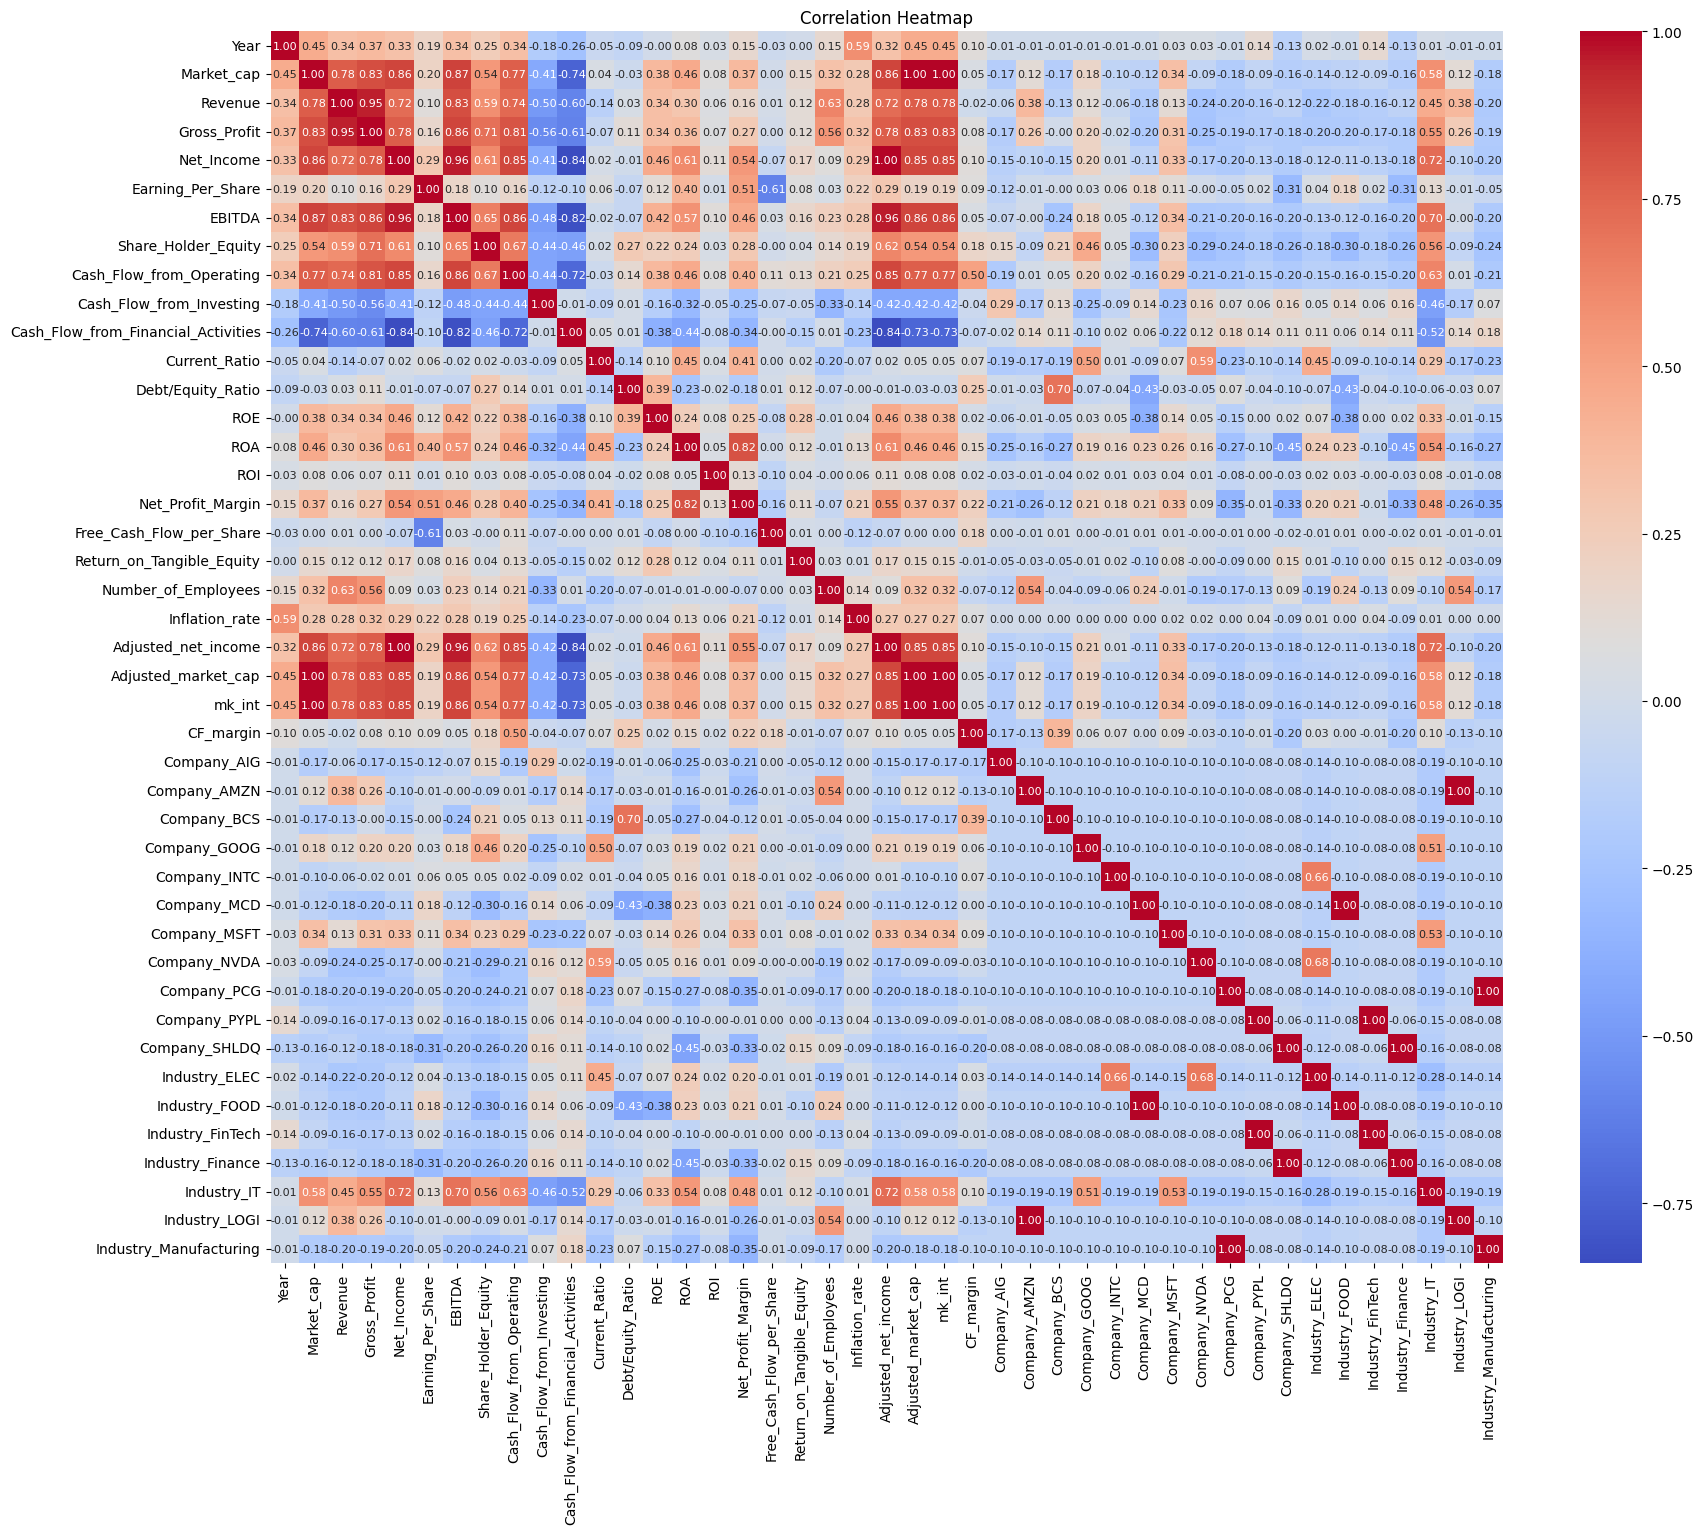

In [18]:
import seaborn as sns

corr_df = pd.get_dummies(df1, drop_first=True)
corr_df['CF_margin'] = corr_df['Cash_Flow_from_Operating'] / corr_df['Revenue']
corr_df.corr()["CF_margin"].sort_values(ascending=False)

corr = np.around(corr_df.corr(), decimals=2)
plt.figure(figsize=(20, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, annot_kws={"size": 8},linecolor="white")
plt.title("Correlation Heatmap")
plt.show()

In [19]:
# Average market cap in each industry

industries = df1['Industry'].unique()

for industry in industries:
    industry_df = df1[df1['Industry'] == industry]
    industry_df = industry_df.groupby('Year')['Market_cap'].mean()
    
    fig = px.line(industry_df, x=industry_df.index, y=industry_df.values, title=f'Average Market Cap for {industry}')
    fig.update_layout(yaxis_title='Market Cap')
    fig.show()

## The average of each columns group by industry

In [20]:
df1_mean_by_category = df1.select_dtypes(include=['float64','int64'])
df1_mean_by_category = df1_mean_by_category.drop(columns=['mk_int'])
df1_mean_by_category = df1_mean_by_category.groupby(df1['Industry']).mean()
df1_mean_by_category

,Year,Market_cap,Revenue,Gross_Profit,Net_Income,Earning_Per_Share,EBITDA,Share_Holder_Equity,Cash_Flow_from_Operating,Cash_Flow_from_Investing,Cash_Flow_from_Financial_Activities,Current_Ratio,Debt/Equity_Ratio,ROE,ROA,ROI,Net_Profit_Margin,Free_Cash_Flow_per_Share,Return_on_Tangible_Equity,Number_of_Employees,Inflation_rate,Adjusted_net_income,Adjusted_market_cap,CF_margin
Industry,,,,,,,,,,,,,,,,,,,,,,,,
Bank,2015.500000,45.718571,47955.100714,25602.957857,2933.221257,-0.819768,7140.214286,88470.506071,14736.142143,1276.838700,-5629.706746,1.000000,3.423086,4.556204,0.493468,2.185818,6.488179,0.489096,5.307804,84742.857143,2.235500,2816.372468,44.758751,0.427134
ELEC,2015.758621,175.882759,33694.644897,19829.039379,7462.370483,1.796034,13070.957097,36600.830310,12257.941103,-7844.646000,-4051.991069,3.638717,0.260959,19.499045,12.239172,15.571717,19.399793,-0.028055,27.385048,57087.862069,2.286000,7276.051160,170.532824,0.308094
FOOD,2015.500000,130.867857,24145.014286,10675.471500,5401.414286,6.171429,9942.793143,3995.185714,6863.707143,-2013.114286,-4742.921429,1.537429,-2.835779,-42.205129,14.299457,19.728271,22.672486,0.532500,-12.581607,321428.571429,2.235500,5274.710571,127.648252,0.287526
FinTech,2018.000000,146.801590,16530.555556,7692.000000,2238.777778,1.876667,3428.333333,16343.555556,4203.888889,-5704.888889,2874.222222,1.368578,0.216444,12.745467,4.319878,10.635922,13.009867,0.345078,24.302778,22411.111111,2.591289,2175.070486,143.267619,0.261095
Finance,2013.500000,3.718000,34558.700000,8734.400000,-1042.900000,-9.821000,17.800000,2699.600000,-584.200000,431.500000,26.200000,1.129060,-0.304400,16.694970,-7.673860,-0.252180,-3.489940,-0.756980,89.023000,220090.000000,1.555050,-1026.628513,3.673318,-0.028932
IT,2015.674419,854.413488,143951.209302,75269.813953,35216.906977,2.818712,50629.465116,107629.720930,49193.465116,-21862.627907,-26088.837209,2.836940,0.416251,36.831828,15.680047,24.892316,24.347523,0.443216,45.182830,109525.604651,2.269558,34152.470650,828.220564,0.352254
LOGI,2015.500000,551.926429,188247.142857,72764.642857,5879.500000,0.580607,19945.357143,42302.571429,21655.357143,-18259.214286,361.000000,1.114400,0.422207,11.197943,3.333736,8.480193,2.353793,-0.081100,14.867950,536050.000000,2.235500,5727.410550,536.182735,0.107767
Manufacturing,2015.500000,22.591429,16874.071429,11819.785714,-284.642857,-0.378571,3035.714286,15480.428571,2326.428571,-5710.642857,3419.500000,0.817836,1.250129,-8.768300,0.046929,-11.312493,-1.463186,-0.196429,-8.768300,22533.785714,2.235500,-281.518596,22.032051,0.150125


In [21]:
fig = px.scatter_3d(df1, x='Earning_Per_Share', y='ROE', z='ROA', color='Company', symbol='Year', opacity=0.7)
fig.show()

## Selecting a target variable

The idea is that we are looking for good stocks to invest based on fundamental analysis. Therefore, we have several options with the following reasons:

- EPS can gauge profitability and growth also meaningful for investors.
- Net Income can represent profitability.
- Market Cap can demonstrate that the business is growing.
- Free Cash Flow per Share can desmonstrate ability to generate cash and be torelent for unexpected circumstances.

In this notebook, __EPS__ is selected.

In [22]:
df1.head()

,Year,Company,Industry,Market_cap,Revenue,Gross_Profit,Net_Income,Earning_Per_Share,EBITDA,Share_Holder_Equity,Cash_Flow_from_Operating,Cash_Flow_from_Investing,Cash_Flow_from_Financial_Activities,Current_Ratio,Debt/Equity_Ratio,ROE,ROA,ROI,Net_Profit_Margin,Free_Cash_Flow_per_Share,Return_on_Tangible_Equity,Number_of_Employees,Inflation_rate,Adjusted_net_income,Adjusted_market_cap,mk_int,CF_margin
0,2009,AMZN,LOGI,58.24,24509.00,5531.00,902.00,0.1020,1507.0,5257.0,3293.00,-2337.00,-280.00,1.3304,0.2007,17.1581,6.5301,17.1581,3.6803,0.3303,22.4211,24300,-0.3555,905.218050,58.447782,58,0.134359
1,2009,INTC,ELEC,112.65,35127.00,19561.00,4369.00,0.7700,10763.0,41704.0,11170.00,-7965.00,-2568.00,2.7871,0.0533,10.4762,8.2286,9.9856,12.4377,1.1789,11.7185,79800,-0.3555,4384.587208,113.051900,113,0.317989
2,2009,AAPL,IT,189.80,42905.00,17222.00,8235.00,0.3243,12474.0,31640.0,10159.00,-17434.00,663.00,2.7425,0.0000,26.0272,17.3365,26.0272,19.1936,0.3550,26.4052,36800,-0.3555,8264.379870,190.477146,190,0.236779
3,2009,BCS,Bank,36.84,45992.04,45992.04,5497.87,5.1200,1.0,91570.7,65523.51,18026.64,-1035.05,1.0000,8.5152,19.5283,0.8282,5.1862,12.0558,21.5535,22.9851,144200,-0.3555,5517.484658,36.971433,37,1.424671
4,2009,AIG,Bank,4.04,75447.00,18614.00,-12244.00,-90.4800,27765.0,98076.0,18584.00,5778.00,-28997.00,1.0000,1.1552,-45.3061,-1.5123,-6.0641,-16.2286,137.3287,-13.9507,96000,-0.3555,-12287.682712,4.054413,4,0.246319


In [23]:
# Drop the adjusted columns because we will keep the inflation rate and original data. Let's see if models can perform well.
cleaned_df = df1.drop(columns=['mk_int','Adjusted_net_income','Adjusted_market_cap','CF_margin'])

In [24]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 161 non-null    int64  
 1   Company                              161 non-null    object 
 2   Industry                             161 non-null    object 
 3   Market_cap                           161 non-null    float64
 4   Revenue                              161 non-null    float64
 5   Gross_Profit                         161 non-null    float64
 6   Net_Income                           161 non-null    float64
 7   Earning_Per_Share                    161 non-null    float64
 8   EBITDA                               161 non-null    float64
 9   Share_Holder_Equity                  161 non-null    float64
 10  Cash_Flow_from_Operating             161 non-null    float64
 11  Cash_Flow_from_Investing        

In [25]:
# Handle outliers
num_types = cleaned_df.select_dtypes(['int64','float64'])

# Visualize with box plots and histogram
fig = px.box(num_types)
fig.show()

fig = px.box(cleaned_df, x='Earning_Per_Share')
fig.show()

fig = px.histogram(cleaned_df, x="Earning_Per_Share")
fig.show()

In [26]:
# %%timeit
# cleaned_df.drop(cleaned_df.query('Earning_Per_Share < -20').index)
# 2.78 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cleaned_df.drop(cleaned_df.loc[cleaned_df['Earning_Per_Share']< -20].index, inplace=True)
# 797 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
fig = px.box(cleaned_df, x='Earning_Per_Share')
fig.show()

## Feature Engineering

The target variable, Earning_Per_Share ('EPS'), is continuous. It needs to transform the continuous variable into in binary (0,1). For doing this, we need to set a threshold for the EPS to determine if each record will fall in 0 or 1.

### Create threshold for target variable classification

This is a binary classification with machine learning approach, Here is my approach:
1. Standardize the data with scaling method
1. Apply Dimension Reduction method and force the method to reduce into 2 components (features)
1. Employ K-means clustering and visualize the result to conclude if it looks good
1. Check Check imbalance to deal with bias for modeling

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



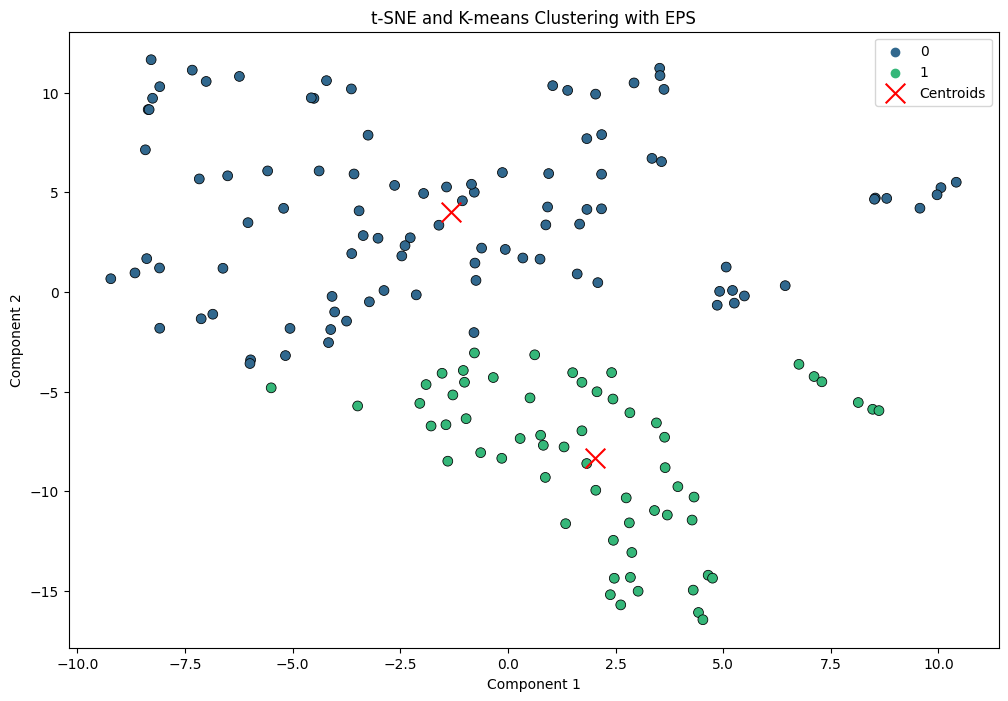

In [27]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

cleaned_df = pd.get_dummies(cleaned_df,drop_first=True)

X = cleaned_df.drop(columns=['Earning_Per_Share'])

# Scaling
rs = RobustScaler()
X_scaled = rs.fit_transform(X)

# Dimension Reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_tsne)

plt.figure(figsize=(12, 8))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=clusters, palette='viridis', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('t-SNE and K-means Clustering with EPS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [28]:
cluster_df = pd.DataFrame({'EPS_Label': clusters}, index=cleaned_df.index)
print(f'Number of each label:\n{cluster_df.value_counts()}')
print("*"*100)

# Add the label to the main dataset
cleaned_df['EPS_label'] = cluster_df['EPS_Label']

Number of each label:
EPS_Label
0            97
1            61
Name: count, dtype: int64
****************************************************************************************************


In [29]:
# Check imbalance classes
imbalance_df = cleaned_df['EPS_label'].value_counts().reset_index()
fig = px.bar(imbalance_df, x='EPS_label', y='count',width=500, height=800)
fig.show()

# Feature Selection

In [30]:
# Feature Selection

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

method = []
acc = []

#define X and y
X = cleaned_df.drop(['Earning_Per_Share', 'Year', 'EPS_label'], axis=1)
y = cleaned_df['EPS_label']

#Method 1: using variance threshold
vt = VarianceThreshold(threshold=0.25)
vt.fit(X)
pd.DataFrame({'variance': vt.variances_,\
             'select_feature':vt.get_support()}, index = X.columns)
X_1 = X.iloc[:, vt.get_support()]
X_1.shape

#Method 2: Use SelectFromModel and LogisticRegression
method2 = SelectFromModel(estimator=LogisticRegression(max_iter=5000))
method2.fit(X,y)

pd.DataFrame({'coef':method2.estimator_.coef_[0],\
             'select_feature':method2.get_support()}, index=X.columns)
X_2 = method2.transform(X)
X_2.shape

#Method 3: Use Generalized Linear Model (Binomial) from statsmodels
X = X.astype(float) #If it is error, it may need to cast type float.
logit_model = sm.GLM(y,X,family=sm.families.Binomial())
result = logit_model.fit(fit_intercept=True)

#Select the features that coefficient value is greater than 0.02
X_3 = X.loc[:,abs(result.params)>=0.1]
X_3.shape

#Method 4: Use Recursive Feature Elimination (RFE) and Logistic Regression
rfe = RFE(estimator=LogisticRegression(max_iter=5000),\
         n_features_to_select=10, step=1)
rfe_result = rfe.fit(X,y)
X_4 = X.loc[:,rfe_result.support_]
X_4.shape

#Method 5: Use SelectFromModel and Random Forest classifier
method5 = SelectFromModel(estimator=RandomForestClassifier(random_state=42, n_estimators=100))
method5.fit(X, y)
X_5 = method5.transform(X)
X_5.shape

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

/opt/conda/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning:

Perfect sepa

(158, 10)

In [31]:
# Evaluate Feature Selection methods

# Performance of Feature Selection Method 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train1, y_train1)
y_pred_1 = logreg.predict(X_test1)
acc_1 = logreg.score(X_test1, y_test1)
method.append('Method 1')
acc.append(acc_1)

# Performance of Feature Selection Method 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y, test_size=0.3, random_state=0)
logreg2 = LogisticRegression(max_iter=5000)
logreg2.fit(X_train2, y_train2)
y_pred_2 = logreg2.predict(X_test2)
acc_2 = logreg2.score(X_test2, y_test2)
method.append('Method 2')
acc.append(acc_2)

# Performance of Feature Selection Method 3
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y, test_size=0.3, random_state=0)
logreg3 = LogisticRegression(max_iter=5000)
logreg3.fit(X_train3, y_train3)
y_pred_3 = logreg3.predict(X_test3)
acc_3 = logreg3.score(X_test3, y_test3)
method.append('Method 3')
acc.append(acc_3)

# Performance of Feature Selection Method 4
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_4, y, test_size=0.3, random_state=0)
logreg4 = LogisticRegression(max_iter=5000)
logreg4.fit(X_train4, y_train4)
y_pred_4 = logreg4.predict(X_test4)
acc_4 = logreg4.score(X_test4, y_test4)
method.append('Method 4')
acc.append(acc_4)

# Performance of Feature Selection Method 5
X_train5, X_test5, y_train5, y_test5 = train_test_split(X_5, y, test_size=0.3, random_state=0)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train5, y_train5)
y_pred_5 = rf.predict(X_test5)
acc_5 = rf.score(X_test5, y_test5)
method.append('Method 5')
acc.append(acc_5)

# Print the feature selection methods in a table format
feature_selection_results = np.vstack( (method, acc)).T
feature_selection_results_df = pd.DataFrame(feature_selection_results, columns=['Method', 'Accuracy'])
feature_selection_results_df

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Method,Accuracy
0,Method 1,0.8958333333333334
1,Method 2,0.7708333333333334
2,Method 3,0.9166666666666666
3,Method 4,0.9375
4,Method 5,0.9583333333333334


In [32]:
# Method 5 (Model Random Forest) gives the best accuracy so we will use this feature selection.
# Check the total number of features from method 5
X_5.shape[1]

10

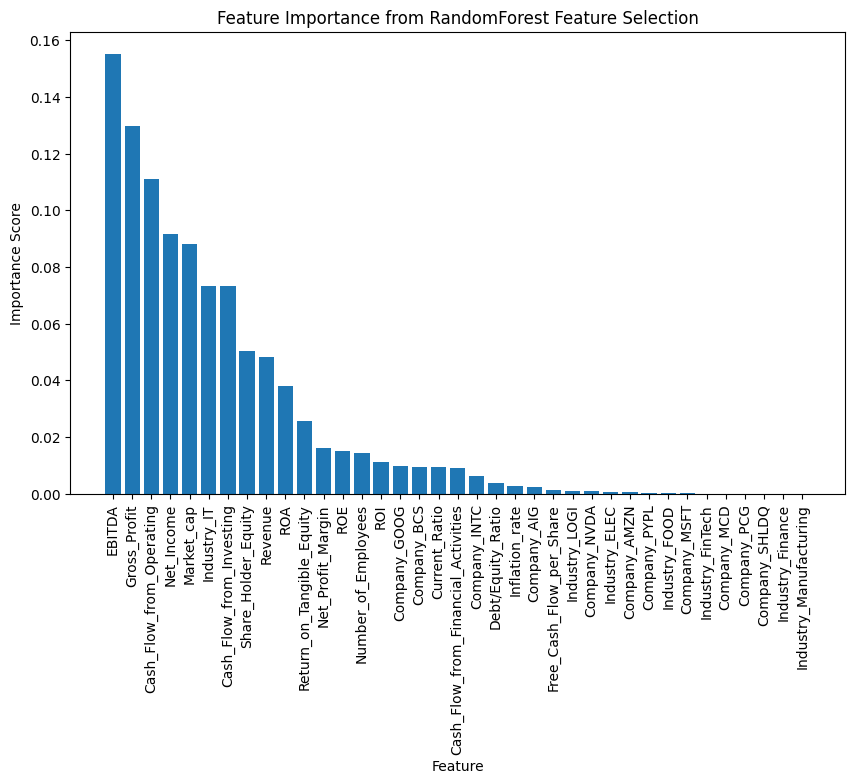

In [33]:
# Visualize the feature importance from Random Forest Feature Selection

feature_importances = method5.estimator_.feature_importances_
# Get the index
feature_idx = np.arange(len(feature_importances))
# Sort features based on importance
sorted_feat = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(feature_idx, feature_importances[sorted_feat], align="center")
plt.xticks(feature_idx, X.columns[sorted_feat], rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance from RandomForest Feature Selection")
plt.show()

## Modeling

In [34]:
# Use the X and y at the time we employed the feature selection method
X_sel = X_5

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

In [35]:
# Apply Classification models
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# name of the algorithms to be using in modeling
names = ["Logististic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM",          
         "Decision Tree", "Naive Bayes", "Random Forest"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel='linear'),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(max_depth=3),
    GaussianNB(),
    RandomForestClassifier()
]

classifier_scores = {}

for classifier, name in zip(classifiers, names):
    pipeline = Pipeline(steps=[
                ('classifier', classifier)
        ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    score = np.mean(scores)
    classifier_scores[name] = score
    
scores_df = pd.DataFrame(list(classifier_scores.items()), columns=['Classifier', 'Accuracy'])
print(scores_df)

# Print the classifier with the best accuracy
best_classifier = max(classifier_scores, key=classifier_scores.get)
print()
print(f"Best Classifier: {best_classifier}")
print(f"Accuracy: {classifier_scores[best_classifier]}")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.10/site-packages/sklearn/

               Classifier  Accuracy
0  Logististic Regression  0.730462
1       Nearest Neighbors  0.960308
2              Linear SVM  0.904923
3                 RBF SVM  0.929231
4           Decision Tree  0.968308
5             Naive Bayes  0.897231
6           Random Forest  0.968308

Best Classifier: Decision Tree
Accuracy: 0.9683076923076923


## Hyperparameter tuning with GridSearchCV

In [36]:
import time

# start time
start_time_tuning = time.time()

best_score = 0
n_estimators_list = [100, 200, 300]
max_depth_list = [5, 10, 15]
min_samples_split_list = [2, 5, 10]
min_samples_leaf_list = [1, 2, 4]

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list:
            for min_samples_leaf in min_samples_leaf_list:
                    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                                                random_state=42)
                    scores = cross_val_score(rf, X_train, y_train, cv=5)
                    score = np.mean(scores)
                    if score > best_score:
                        best_score = score
                        best_hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
                                            'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

print("Best score:", best_score)
print("Best hyperparameters:", best_hyperparams)

tuned_rf = RandomForestClassifier(**best_hyperparams, random_state=42)
tuned_rf.fit(X_train, y_train)

score_test = tuned_rf.score(X_test, y_test)
print("Test score:", score_test)

# end time
end_time_tuning = time.time()

# Calculate the runtime
runtime_tuning = end_time_tuning - start_time_tuning
print("Runtime for hyperparameter tuning:", runtime_tuning, "seconds")

Best score: 0.9763076923076923
Best hyperparameters: {'n_estimators': 100, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}
Test score: 1.0
Runtime for hyperparameter tuning: 173.77923965454102 seconds


# Evaluation

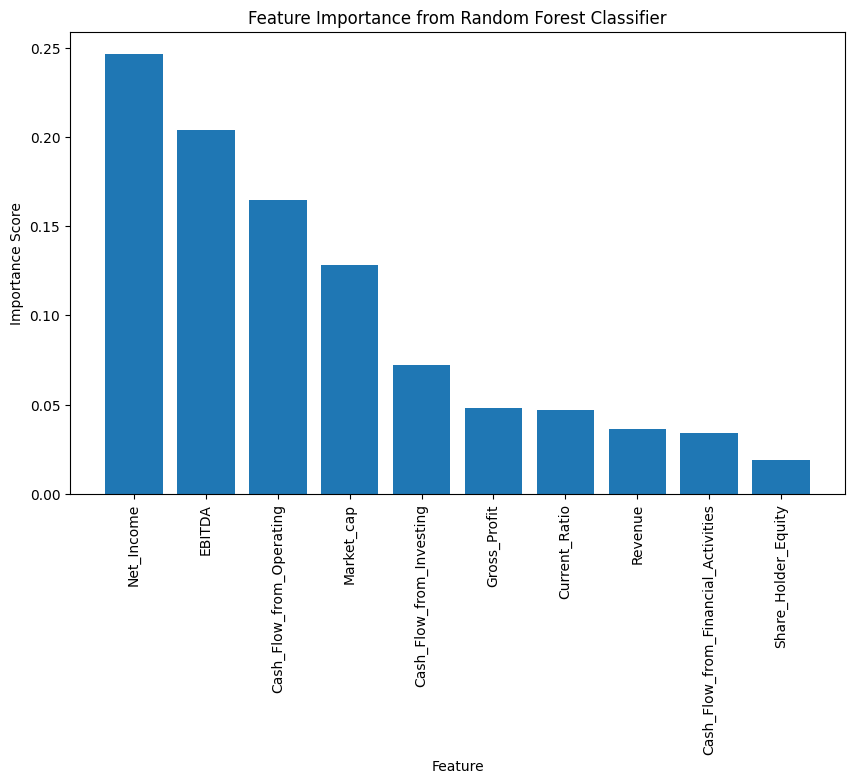

In [37]:
# Visualize the feature importance from Random Forest Classifier

feature_importances = tuned_rf.feature_importances_
# Get the index
feature_idx = np.arange(len(feature_importances))
# Sort features based on importance
sorted_feat = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(feature_idx, feature_importances[sorted_feat], align="center")
plt.xticks(feature_idx, X.columns[sorted_feat], rotation='vertical')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance from Random Forest Classifier")
plt.show()

<Axes: xlabel='Predicted', ylabel='Actual'>

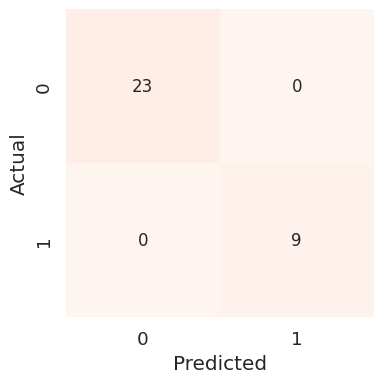

In [38]:
# Confusion Matrix

from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix

y_pred = tuned_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test),
                     index= np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (4,4))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, annot_kws={'size': 12},
           cbar=False, vmax=500, square=True, fmt="d", cmap="Reds")

In [39]:
# Accuracy

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [40]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



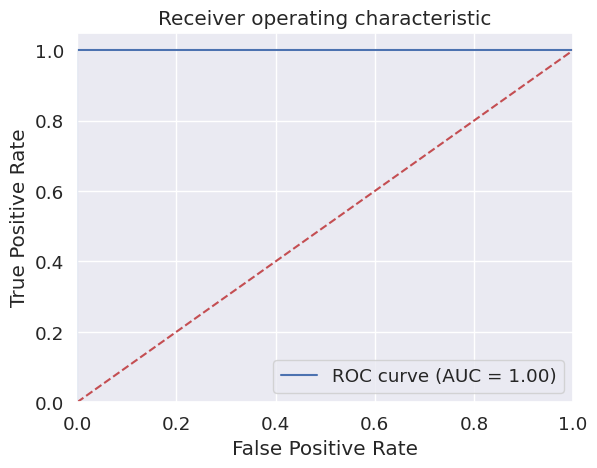

AUC: 1.0


In [41]:
# ROC

# Create a probability result for RandomForest
tuned_rf = RandomForestClassifier(**best_hyperparams)
tuned_rf.fit(X_train, y_train)
tuned_rf_prob = tuned_rf.predict_proba(X_test)[:,1]

# Create ROC
tuned_rf_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_rf_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='Tuned RandomForest' % tuned_rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(['ROC curve (AUC = {:.2f})'.format(roc_auc)], loc='lower right')
plt.show()
print("AUC:", roc_auc)

# Executive Summary
- AAPL net income and EPS grew gradually with a consistent cash flow margin.
- MFST had the best cash flow margin compared with the others in the IT industry.
- AIG EPS was very fluctuated and cash flow margin was very low and negative in some years.
- PYPL turned the EPS into positive in 2019 and plateau afterward.

# Modeling Result
- Random forest is the best model with the accuracy at 0.98 after parameter tuning.
- The evaluation showed the accuracy at 1.00 so the model might be overfitting although cross validation was employed. This issue may be caused by the small dataset and few companies for the modeling.
- Net income is the most important feature with the score of 0.25 followed by EBITDA while share holder equity has the lowest score.